In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras 
import cv2
import os
import glob
from PIL import Image
from matplotlib import pyplot as plt

2024-06-30 05:26:20.685734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 05:26:20.685838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 05:26:20.845505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_images_from_folder(folder_path, target_size=(256,256)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path)
                img = img.resize(target_size) 
                img_array = np.array(img)
                if img_array.shape[-1] == 3:  
                    img_array = img_array / 255.0  
                    images.append(img_array)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images)

In [3]:
low_array = load_images_from_folder('/kaggle/input/low-light-denoising/Train/low')
high_array = load_images_from_folder("/kaggle/input/low-light-denoising/Train/high")

In [4]:
train_low=low_array[:int(0.9*low_array.shape[0])]
test_low=low_array[int(0.9*low_array.shape[0]):]

train_high=high_array[:int(0.9*high_array.shape[0])]
test_high=high_array[int(0.9*high_array.shape[0]):]

In [5]:
def downsampling(x,y):
    input_img = keras.Input(shape=(256//y,256//y,64*y))
    conv1=keras.layers.Conv2D(filters=64,kernel_size=(1,1),strides=1,padding="same")(input_img)
    conv2=keras.layers.PReLU()(conv1)
    conv3=keras.layers.Conv2D(filters=64,kernel_size=(1,1),strides=1,padding="same")(conv2)
    conv4=keras.layers.PReLU()(conv3)
    conv5=keras.layers.MaxPool2D(pool_size=(x,x))(conv4)
    conv6=keras.layers.Conv2D(filters=64*y*x,kernel_size=(1,1),strides=1,padding="same")(conv5)
    conv7=keras.layers.MaxPool2D(pool_size=(x,x))(input_img)
    conv8=keras.layers.Conv2D(filters=64*y*x,kernel_size=(1,1),strides=1,padding="same")(conv7)
    output=conv6+conv8
    
    return keras.Model(inputs=input_img, outputs=output)
# output_shape=(600//x,400//x,filters*x)

In [6]:
def upsampling(x,y):
    input_img = keras.Input(shape=(256//y,256//y,64*y))
    conv1=keras.layers.Conv2D(filters=64,kernel_size=(1,1),strides=1,padding="same")(input_img)
    conv2=keras.layers.PReLU()(conv1)
    conv3=keras.layers.Conv2D(filters=64,kernel_size=(1,1),strides=1,padding="same")(conv2)
    conv4=keras.layers.PReLU()(conv3)
    conv5=keras.layers.UpSampling2D((x,x))(conv4)
    conv6=keras.layers.Conv2D(filters=(64*y)//x,kernel_size=(1,1),strides=1,padding="same")(conv5)
    conv7=keras.layers.UpSampling2D((x,x))(input_img)
    conv8=keras.layers.Conv2D(filters=(64*y)//x,kernel_size=(1,1),strides=1,padding="same")(conv7)
    output=conv6+conv8
    
    return keras.Model(inputs=input_img, outputs=output)
# output_shape=(600*x,400*x,filters//x)


In [7]:
def CA(y):
    input_img = keras.Input(shape=(256//y,256//y, 64))
    conv1=keras.layers.GlobalAvgPool2D(data_format="channels_last",keepdims=True)(input_img)
    conv2=keras.layers.Conv2D(filters=64//2,kernel_size=(1,1),strides=1,padding="same")(conv1)
    conv3=keras.layers.PReLU()(conv2)
    conv4=keras.layers.Conv2D(filters=64,kernel_size=(1,1),strides=1,padding="same",activation='sigmoid')(conv3)
    output=keras.layers.multiply([conv4,input_img])

    return keras.Model(inputs=input_img, outputs=output)
# output_shape=(400,600,64)

In [8]:
def global_avg_pool(x):
    return tf.reduce_mean(x, axis=3, keepdims=True)

def global_max_pool(x):
    return tf.reduce_max(x, axis=3, keepdims=True)

In [9]:
def SA(y):
    input_img = keras.Input(shape=(256//y,256//y,64))
    conv1=keras.layers.Lambda(lambda x:global_avg_pool(x))(input_img)
    conv2=keras.layers.Lambda(lambda x:global_max_pool(x))(input_img)
    conv3=keras.layers.Concatenate(axis=3)([conv1, conv2])
    conv4=keras.layers.Conv2D(filters=1,kernel_size=(1,1),strides=1,padding="same",activation='sigmoid')(conv3)
    output=keras.layers.multiply([conv4,input_img])

    return keras.Model(inputs=input_img,outputs=output)
# output_shape=(400,600,64)

In [10]:
def DAU(x,shape):
        input_img=keras.Input(shape=shape)
        conv1=keras.layers.Conv2D(filters=64,kernel_size=1,strides=1,padding="same")(input_img)
        conv2=keras.layers.PReLU()(conv1)
        conv3=keras.layers.Conv2D(filters=64,kernel_size=1,strides=1,padding="same")(conv2)
        conv4=SA(x)(conv3)
        conv5=CA(x)(conv3)
        conv6=keras.layers.Concatenate(axis=3)([conv4,conv5])
        conv7=keras.layers.Conv2D(filters=shape[2],kernel_size=3,strides=1,padding="same")(conv6)
        output=conv7+input_img

        return keras.Model(inputs=input_img,outputs=output)

# output_shape=[data.shape[1],data.shape[2],filters]

In [11]:
def first_Skff():
    data1=keras.Input(shape=(256,256,64))
    data2=keras.Input(shape=(128,128,128))
    data3=keras.Input(shape=(64,64,256))
    conv1=upsampling(2,2)(data2)
    conv2=upsampling(4,4)(data3)
    conv3=keras.layers.Add()([conv1,conv2,data1])
    conv4=keras.layers.GlobalAvgPool2D(data_format="channels_last",keepdims=True)(conv3)
    conv5=keras.layers.Conv2D(filters=8,kernel_size=3,strides=1,padding="same")(conv4)
    conv6=keras.layers.PReLU()(conv5)
    conv7=keras.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding="same")(conv6)
    conv8=keras.layers.Softmax()(conv7)
    conv9=keras.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding="same")(conv6)
    conv10=keras.layers.Softmax()(conv9)
    conv11=keras.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding="same")(conv6)
    conv12=keras.layers.Softmax()(conv11)
    conv13=keras.layers.multiply([conv8,data1])
    conv14=keras.layers.multiply([conv10,conv1])
    conv15=keras.layers.multiply([conv12,conv2])
    output=keras.layers.Add()([conv13,conv14,conv15])

    return keras.Model(inputs=[data1,data2,data3],outputs=output)

In [12]:
def second_Skff():
    data1=keras.Input(shape=(256,256,64))
    data2=keras.Input(shape=(128,128,128))
    data3=keras.Input(shape=(64,64,256))
    conv1 = downsampling(2,1)(data1)
    conv2 = upsampling(2,4)(data3)
    conv3=conv1+conv2+data2
    conv4=keras.layers.GlobalAvgPool2D(data_format="channels_last",keepdims=True)(conv3)
    conv5=keras.layers.Conv2D(filters=16,kernel_size=3,strides=1,padding="same")(conv4)
    conv6=keras.layers.PReLU()(conv5)
    conv7=keras.layers.Conv2D(filters=128,kernel_size=3,strides=1,padding="same")(conv6)
    conv8=keras.layers.Softmax()(conv7)
    conv9=keras.layers.Conv2D(filters=128,kernel_size=3,strides=1,padding="same")(conv6)
    conv10=keras.layers.Softmax()(conv9)
    conv11=keras.layers.Conv2D(filters=128,kernel_size=3,strides=1,padding="same")(conv6)
    conv12=keras.layers.Softmax()(conv11)
    conv13=keras.layers.multiply([conv8,conv1])
    conv14=keras.layers.multiply([conv10,data2])
    conv15=keras.layers.multiply([conv12,conv2])
    output=keras.layers.Add()([conv13,conv14,conv15])

    return keras.Model(inputs=[data1,data2,data3],outputs=output)

In [13]:
def third_Skff():
    data1=keras.Input(shape=(256,256,64))
    data2=keras.Input(shape=(128,128,128))
    data3=keras.Input(shape=(64,64,256))
    conv1 = downsampling(2,2)(data2)
    conv2 = downsampling(4,1)(data1)
    conv3=conv1+conv2+data3
    conv4=keras.layers.GlobalAvgPool2D(data_format="channels_last",keepdims=True)(conv3)
    conv5=keras.layers.Conv2D(filters=32,kernel_size=3,strides=1,padding="same")(conv4)
    conv6=keras.layers.PReLU()(conv5)
    conv7=keras.layers.Conv2D(filters=256,kernel_size=3,strides=1,padding="same")(conv6)
    conv8=keras.layers.Softmax()(conv7)
    conv9=keras.layers.Conv2D(filters=256,kernel_size=3,strides=1,padding="same")(conv6)
    conv10=keras.layers.Softmax()(conv9)
    conv11=keras.layers.Conv2D(filters=256,kernel_size=3,strides=1,padding="same")(conv6)
    conv12=keras.layers.Softmax()(conv11)
    conv13=keras.layers.multiply([conv8,conv1])
    conv14=keras.layers.multiply([conv10,conv2])
    conv15=keras.layers.multiply([conv12,data3])
    output=keras.layers.Add()([conv13, conv14,conv15]) 

    return keras.Model(inputs=[data1,data2,data3],outputs=output)

In [14]:
def MRB():
        inputs=keras.Input(shape=(256,256,64))
        conv1=downsampling(1,1)(inputs)#(400,600,64)--->(400,600,64)
        conv2=downsampling(2,1)(inputs)#(400,600,64)--->(200,300,128)
        conv3=downsampling(4,1)(inputs)#(400,600,64)--->(100,150,256)
        conv4=keras.layers.Lambda(DAU(1,(256,256,64)))(conv1)#(400,600,64)-->(400,600,64)
        conv5=keras.layers.Lambda(DAU(2,(256//2,256//2,64*2)))(conv2)#(200,300,128)-->(200,300,128)
        conv6=keras.layers.Lambda(DAU(4,(256//4,256//4,64*4)))(conv3)#(100,150,256)-->(100,150,256)
        conv10=first_Skff()([conv4,conv5,conv6])#(400,600,64)-->(400,600,64)
        conv11=second_Skff()([conv4,conv5,conv6])#all three-->(200,300,128)
        conv12=third_Skff()([conv4,conv5,conv6])#all three-->(100,150,256)
        conv13=DAU(1,(256,256,64))(conv10)#(400,600,64)-->(400,600,64)
        conv14=DAU(2,(256//2,256//2,64*2))(conv11)#(400,600,64)-->(200,300,128)
        conv15=DAU(4,(256//4,256//4,64*4))(conv12)#(400,600,64)-->(100,150,256)
        conv17=first_Skff()([conv13,conv14,conv15])#(400,600,64)-->(400,600,64)
        conv18=keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=1,padding="same")(conv17)#(400,600,64)-->
        output=inputs+conv18
        return keras.Model(inputs=inputs,outputs=output)

# output_shape=[input.shape[1],input.shape[2],filter]


In [15]:
def RRG():
        inputs=keras.Input(shape=(256,256,64))
        conv1 = MRB()(inputs)
        conv2 = MRB()(conv1)
        output = inputs+conv2
        return keras.Model(inputs=inputs,outputs=output)

In [16]:
def network():
    inputs=keras.Input(shape=(256,256,3))
    conv1=keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=1,padding="same")(inputs)
    conv2=RRG()(conv1)
    conv3=RRG()(conv2)
    conv4=RRG()(conv3)
    conv5=keras.layers.Convolution2D(filters=3,kernel_size=(3,3),strides=1,padding="same")(conv4)
    output=conv5+inputs
    return keras.Model(inputs=inputs, outputs=output)
    
  

In [17]:
def Charbonnier_loss(y_true,data,epsilon=1e-3):
    diff = y_true - data
    loss = tf.reduce_mean(tf.sqrt(tf.square(diff) + tf.square(epsilon)))
    return loss

In [18]:
class Model(keras.Model):
    def __init__(self, **kwargs):
        super(Model, self).__init__(**kwargs)
        self.model = network()
       
    def compile(self, learning_rate, **kwargs):
        super(Model, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    def compute_losses(self, y_true, data, epsilon=1e-3):
        loss = Charbonnier_loss(y_true, data, epsilon)
        return {"losses": loss}
    
    def call(self, data):
        inputs, y_true = data
        net_output = self.model(inputs)
        return net_output
    

    def train_step(self, data):
        inputs, y_true = data
        with tf.GradientTape() as tape:
            output = self.model(inputs, training=True)
            loss = self.compute_losses(y_true, output)
        grads = tape.gradient(loss["losses"], self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return loss

    
    def test_step(self, data):
        inputs, y_true = data
        output = self.model(inputs)
        losses = self.compute_losses(y_true, output)["loss"]
        return {'loss': losses}
    
    def output_show(self, data):
        for i in range(data.shape[0]):
            input_data = data[i:i+1, :, :, :]
            output = self.model(input_data)
            image = tf.cast(output * 255, tf.uint8)
            image = np.squeeze(image)
            plt.imshow(image)
            plt.show()
    
    def calculate_psnr(self, input_image, second_image):
        output = self.model(input_image)
        squared_diff = tf.square(output - second_image)
        mse = tf.reduce_mean(squared_diff)
        max_pixel = 1.0
        psnr = 20 * tf.math.log(max_pixel) / tf.math.log(10.0) - 10 * tf.math.log(mse) / tf.math.log(10.0)
        return psnr.numpy()

In [19]:
def dummy_loss():
    return tf.constant(0.0)

In [20]:
model = Model()
model.compile(learning_rate=0.000005,loss=dummy_loss())
history = model.fit(train_low,train_high,batch_size=1,epochs=50)


Epoch 1/50


W0000 00:00:1719725648.105537      73 hlo_rematerialization.cc:2946] Can't reduce memory use below 7.21GiB (7737440879 bytes) by rematerialization; only reduced to 11.44GiB (12281091164 bytes), down from 13.62GiB (14622393004 bytes) originally
I0000 00:00:1719725723.806400      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


436/436 ━━━━━━━━━━━━━━━━━━━━ 788s 658ms/step - losses: 0.2557
Epoch 2/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 288s 662ms/step - losses: 0.1596
Epoch 3/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 286s 656ms/step - losses: 0.1577
Epoch 4/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 289s 662ms/step - losses: 0.1561
Epoch 5/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 287s 658ms/step - losses: 0.1549
Epoch 6/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 325s 664ms/step - losses: 0.1536
Epoch 7/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 290s 664ms/step - losses: 0.1528
Epoch 8/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 288s 661ms/step - losses: 0.1515
Epoch 9/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 289s 662ms/step - losses: 0.1508
Epoch 10/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 290s 666ms/step - losses: 0.1497
Epoch 11/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 290s 665ms/step - losses: 0.1479
Epoch 12/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 287s 659ms/step - losses: 0.1473
Epoch 13/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 290s 665ms/step - losses: 0.1457
Epoch 14/50
436/436 ━━━━━━━━━━━━━━━━━━━━ 288s 661ms/step -

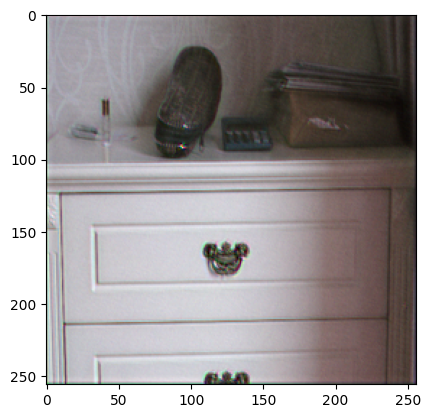

20.416634


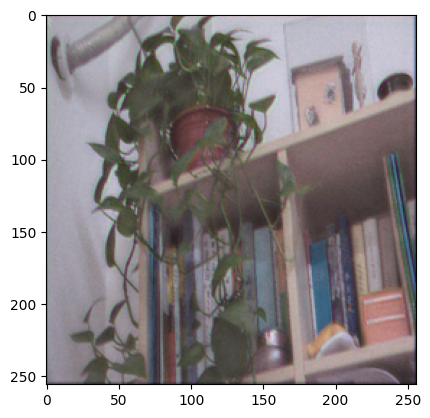

21.462795


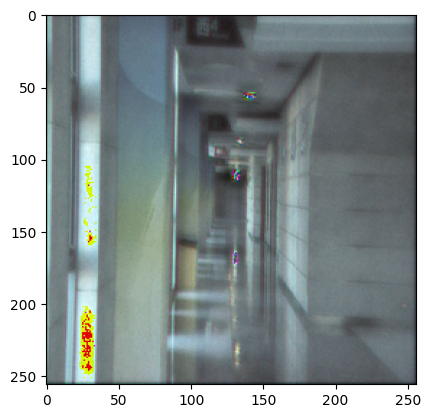

19.20298


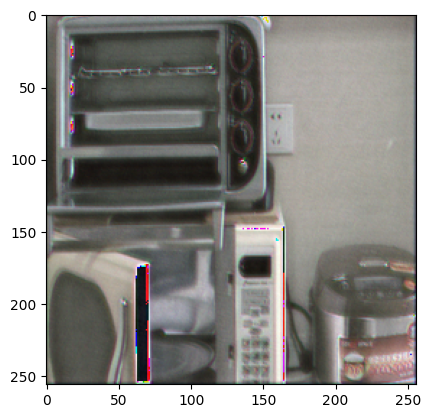

23.29352


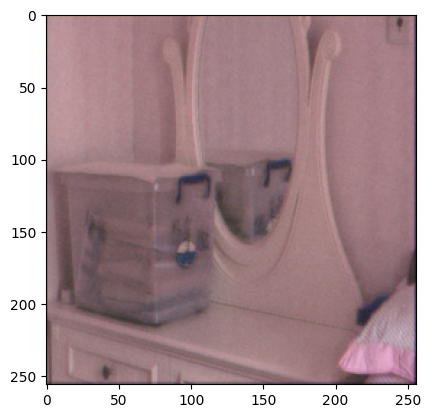

27.13152


In [21]:
for i in range(5):
    model.output_show(test_low[i:i+1])
    print(model.calculate_psnr(test_low[i:i+1],test_high[i:i+1]))

In [22]:
model.save_weights('gfgModel1.weights.h5')
print('Model Saved!')

Model Saved!
